In [1]:
import csv
import dis
import inspect
import os
import sys
import time


import astropy
import astroquery
# import eleanor ## alternative for TESS data analysis
import lightkurve as lk ## for importing and manipulating TESS data
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from astropy import units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from astropy.visualization import time_support
time_support()
from astropy.visualization import quantity_support
quantity_support()

from lightkurve import search_targetpixelfile

from numpy import interp

from sklearn import preprocessing as pp

from scipy import linalg as la
from scipy import optimize
from scipy import integrate

from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import binom

from IPython.display import display_html
from IPython.display import Image

%matplotlib inline

## set seed for reproducibility
random.seed(5731)

In [2]:
## read in data using astropy.io.fits 
fits_file = fits.open('./data/lc.fits')
fits_file.info()
print()

## read in the light curve data as a pandas dataframe
df = pd.DataFrame(fits_file[1].data)

Filename: ./data/lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   18231R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   



In [3]:
popOutlier = True
if popOutlier:
    df = df[(df['PDCSAP_FLUX'] <= 8590) | (np.isnan(df['PDCSAP_FLUX']))]

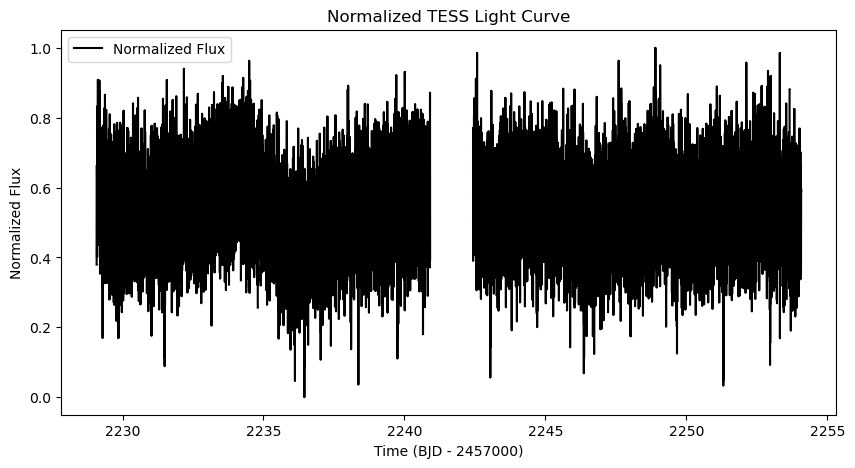

In [4]:
## retreive the flux data and flux error as numpy arrays to process

flux = df['PDCSAP_FLUX'].astype(float)
flux_err = df['PDCSAP_FLUX_ERR'].astype(float)

## find the max and min flux values
max_flux = np.max(flux)
min_flux = np.min(flux)

## define normalization function and 
norm_x = lambda x: np.abs((x - np.min(x))/(np.max(x) - np.min(x)))
norm_flux = norm_x(flux)
#norm_flux_err = norm(flux_err)

## normalize flux error by taking the ratio of the normalized flux to the original flux for each data point
norm_ratio = norm_flux/flux ## will be less than 1
norm_flux_err = norm_ratio*flux_err ## will be less than flux_err


## add normalized flux and flux error to the dataframe
df['NORM_FLUX'] = norm_flux
df['NORM_FLUX_ERR'] = norm_flux_err
norm_flux_mean = df['NORM_FLUX'].mean()

## plot the normalized flux data
df.plot(x='TIME', y='NORM_FLUX', yerr='NORM_FLUX_ERR', figsize=(10,5), color='black', label='Normalized Flux', title='Normalized TESS Light Curve',alpha=1)
plt.xlabel('Time (BJD - 2457000)');
plt.ylabel('Normalized Flux');  
plt.show();

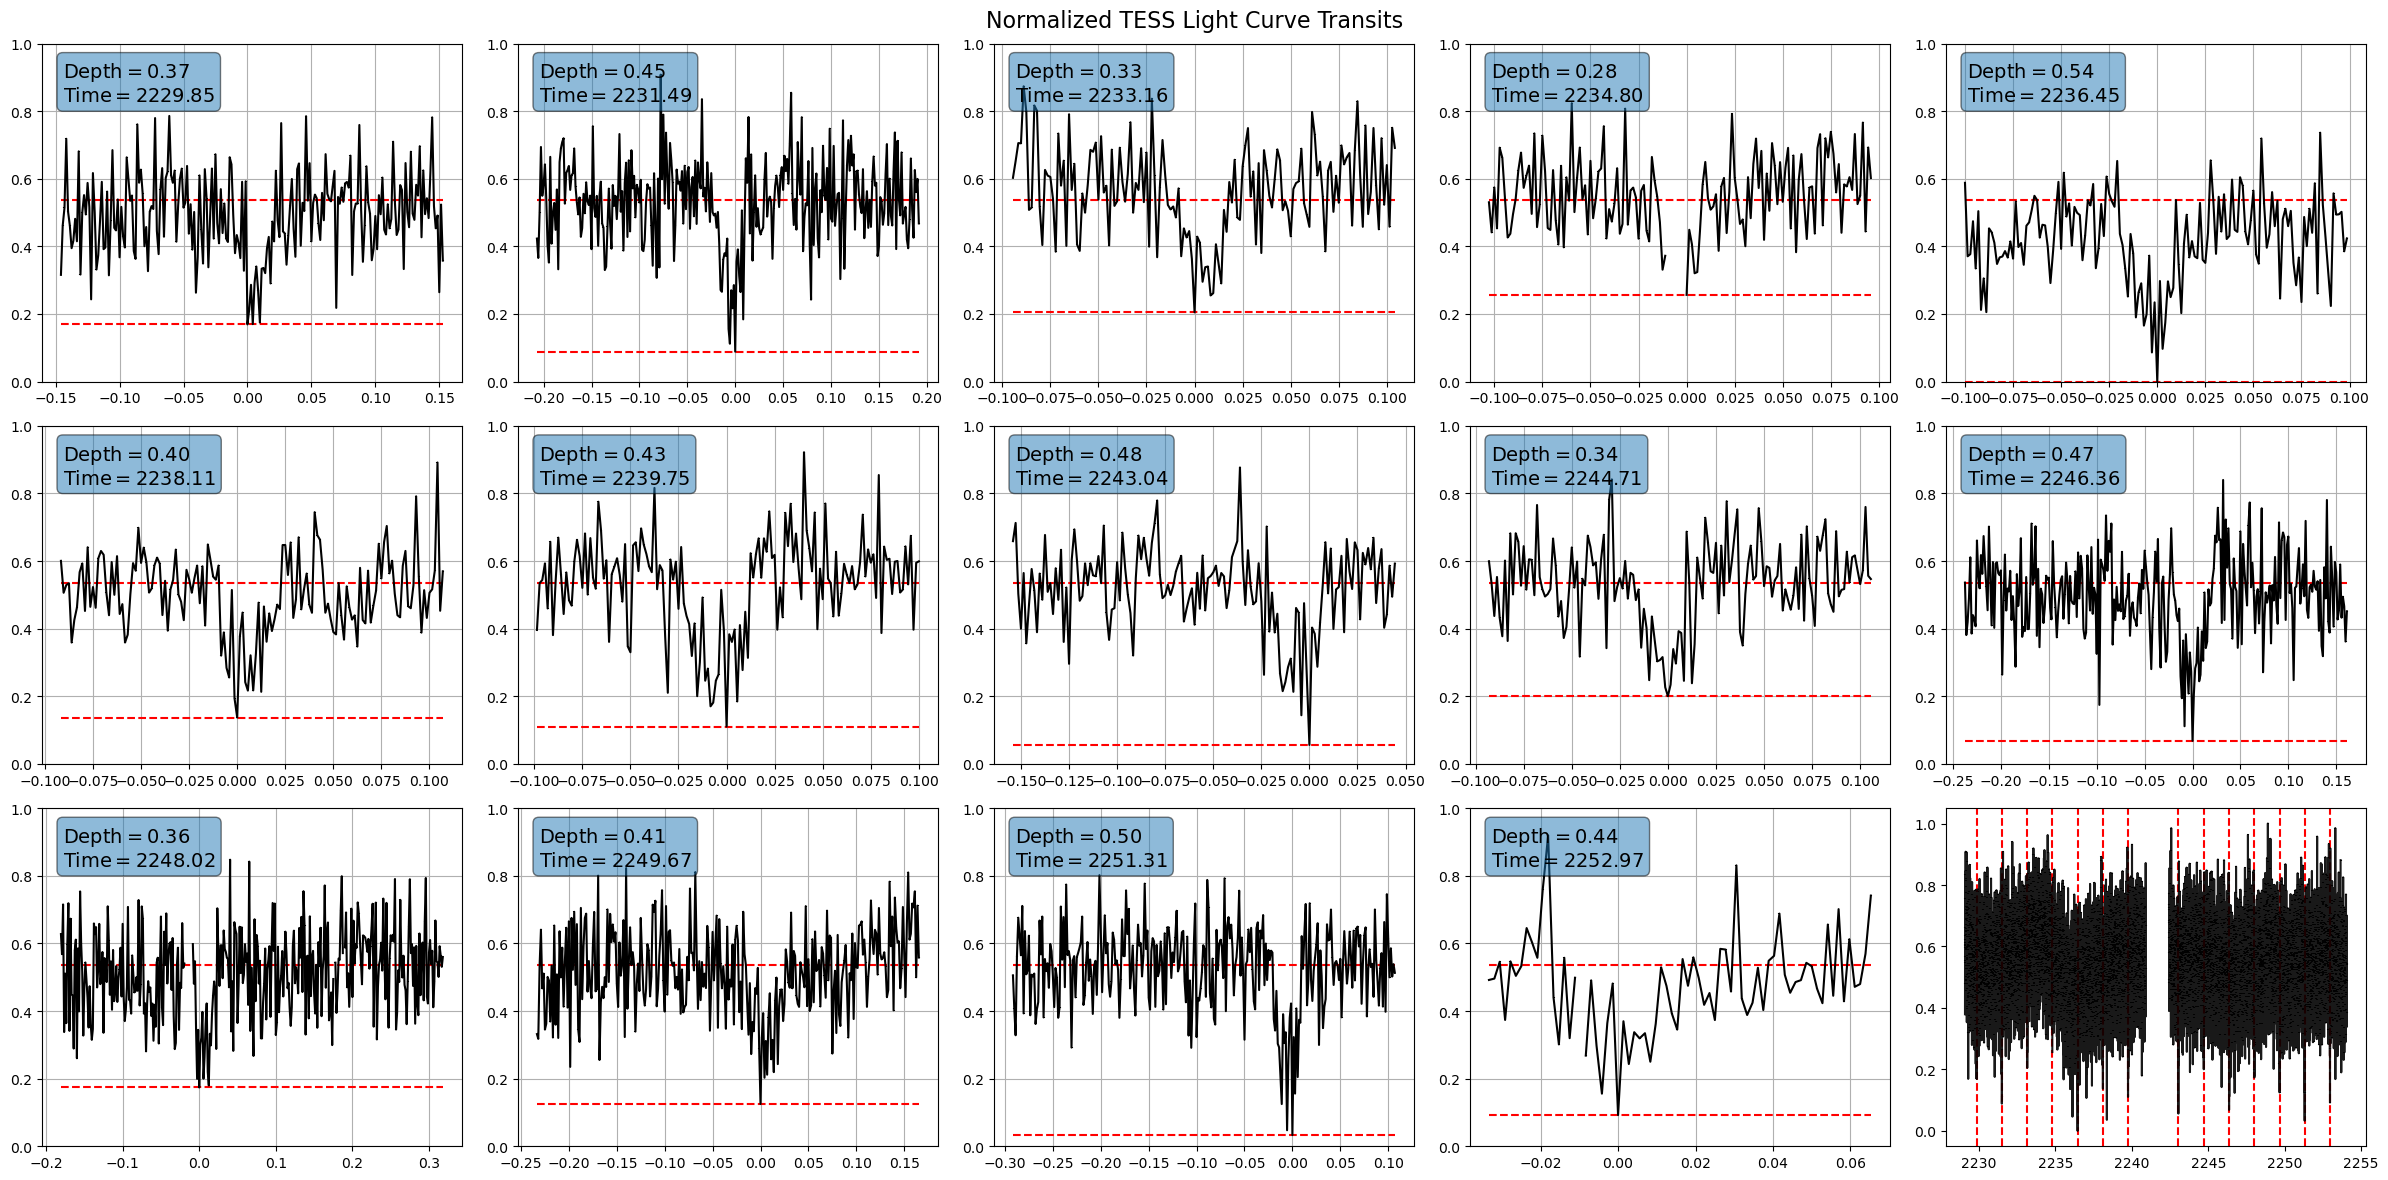

Transit Depths stored in data frame 'tdf':


,Transit,Time,Depth
0,t01,2229.853950,0.367170
1,t02,2231.492896,0.447713
2,t03,2233.155448,0.331561
3,t04,2234.797162,0.279767
4,t05,2236.449981,0.536357
5,t06,2238.106961,0.399121
6,t07,2239.750045,0.425779
7,t08,2243.044534,0.480136
8,t09,2244.705672,0.335874
9,t10,2246.361248,0.467967


In [5]:
## define function to seperate data into transits and plot them in subplots
transit_times = {
    't01': [2229.7, 2230],
    't02': [2231.3, 2231.7],
    't03': [2233.05, 2233.25],
    't04': [2234.7, 2234.9],
    't05': [2236.35, 2236.55],
    't06': [2238, 2238.2],
    't07': [2239.65, 2239.85],
    't08': [2243, 2243.2],
    't09': [2244.6, 2244.8],
    't10': [2246.2, 2246.6],
    't11': [2247.7, 2248.2],
    't12': [2249.5, 2249.9],
    't13': [2251.2, 2251.6],
    't14': [2252.9, 2253],
}

def transits(df, times, plot=True, save=False):
    '''
    Creates a dataframe of the time and depth of each transit and also plots them
    '''

    fig, axs = plt.subplots(3,5, figsize=(24, 12)) 
    fig.set_facecolor('white') 
    idx=0 ##counter for subplot index
    depths = {} ## dictionary to store transit depths
    times = {} ## dictionary to store the width of each transit
    for key, value in transit_times.items():
        
        transit = df[(df['TIME'] > value[0]) & (df['TIME'] < value[1])]
        min_flux = np.min(transit['NORM_FLUX'])
        depths[key] = norm_flux_mean - min_flux
        #times[key] = interp(min_flux, transit['NORM_FLUX'], transit['TIME'])
        times[key] = transit['TIME'][transit['NORM_FLUX'].idxmin()]

        if plot:
            ax = axs.flatten()[idx]
            relative_time = times[key] - transit['TIME']
            ax.errorbar(relative_time, transit['NORM_FLUX'], yerr=transit['NORM_FLUX_ERR'], color='black', label=key)
            #transit.plot(x=relative_time, y='NORM_FLUX', yerr='NORM_FLUX_ERR', ax=ax, color='black', label=key)
            ax.hlines(norm_flux_mean, relative_time.min(), relative_time.max(), color='r', linestyle='--', label='Mean Flux')
            ax.hlines(min_flux, relative_time.min(), relative_time.max(), color='r', linestyle='--', label='Transit Depth')
            ax.set_ylim(0, 1)
            ax.grid()

            textstr = '\n'.join((
                r'$\mathrm{Depth}=%.2f$' % (depths[key], ),
                r'$\mathrm{Time}=%.2f$' % (times[key], )))
            props = dict(boxstyle='round', alpha=0.5)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
            
        idx+=1
    ## hide the empty subplot
    #axs.flatten()[14].set_visible(False)

    ## Alternate option: on the 14th subplot, plot the entire light curve with axv lines for each transit
    ax = axs.flatten()[14]
    ax.errorbar(df['TIME'], df['NORM_FLUX'], yerr=df['NORM_FLUX_ERR'], color='black', label='Normalized Flux',alpha=0.9)
    #ax.hlines(norm_flux_mean, df['TIME'].min(), df['TIME'].max(), color='r', linestyle='--', label='Mean Flux')
    [ax.axvline(x=times[key], color='r', linestyle='--') for key in times.keys()]   

    fig.suptitle('Normalized TESS Light Curve Transits', fontsize=16)
    plt.tight_layout()
    fig.save('transits.png') if save else None
    plt.show();
    ## combine dictionaries into one before converting into a dataframe
    tDict = {'Transit': list(times.keys()), 'Time': list(times.values()),'Depth': list(depths.values())}
    tdf = pd.DataFrame.from_dict(tDict)

    return tdf

tdf = transits(df=df, times=transit_times, plot=True, save=False)


print("Transit Depths stored in data frame 'tdf':")
display(tdf)

### Bayesian Analysis

1. **Parameter**: $\theta$, the mean of the transit depth.
2. **Parameter Space**: $\Theta$ = [0, 1], since normailzing the data constrained the samples to range between 0 and 1.
3. **Data characteristics**: $x_i$, $i$ = 1,..., 14, where each $x_i$ is a transit depth measurement.
4. **Sample Space**: $\mathscr{X}$, all possible vectors of 14 real-valued numbers between zero and one, since normailzing the data constrained the samples to range between 0 and 1.
5. **Likelihood**: 
        We assume the repeated measures of TOI-564 b's transit depth are normally distrubuted and centered around the true mean of the transit depth. In effect, each measurement
        $$
        X_{i} \sim N(\theta, v) \text{ for } i = 1,...,14
        $$
        Where $\theta$ is the mean of the transit depth measurments and $v$ is the variance of the measurments. We will choose $v$ to be the sample variance(??).
        Thus, our likelihood is
        $$
        p(x | \theta) \sim N(\theta, v) \text{ for } i = 1,...,14.
        $$
6. **Prior**:

        We are trying to estimate the mean of the transit depth using repeated measures, which means that the posterior distribution for $\theta$ should be normal. We will assume our prior is normally distrubuted to utulize the Normal-Normal conjugate set-up.
        That is, 
        $$
        \nu(\theta) \sim N(a, b)
        $$
        The mean must lie between zero and one due to our normalization of the data, so we will choose our prior mean $a$ = 0.5, and our prior variance to be $b$ = $\frac{1}{36}$. This will make both zero and one 3 standard deviations away from the mean, giving any values outside of our parameter space a very low probability.

**Posterior**: Our posterior $q(\theta | x)$ is as follows:
$$
q(\theta | x) = \frac{p(x | \theta) \nu(x)}{p(x)}
        \propto exp \left\{ \frac{1}{2v}\sum_{i = 1}^{n}(x_i - \theta)^2 \right\} exp \left\{ -\frac{1}{2b}(\theta - a)^2 \right\}
$$

where $p(x | \theta)$ is the likelihood function, $p(x)$ is the marginal probability, $n$ is the number of repeated measures, 14, and $a$ and $b$ are as defined above.

Thus, our posterior mean is:
$$
\left(\frac{14}{v} + \frac{1}{1 / 36} \right)^{-1}\left(\frac{14\bar{x}}{v} + \frac{0.5}{1 / 36}\right)
$$
and our posterior variance is:
$$
\left(\frac{14}{v} + \frac{1}{1 / 36} \right)^{-1}
$$
calculated below.

In [6]:
#### Functions to calculate parameters and plot distributions ###

### function for posterior variance ###
# Input: n - number of observations
#        v - variance of likelihood distribution
#        b - b from prior function
#
# Output: posterior variance
# ---------------------------------------
def findVar(n, v, b):
    return (1./(n/v+1/b))

### function for posterior mean ###
# Input: n - number of observations
#        samp_mean - sample mean of observations
#        v - variance of likelihood distribution
#        a, b - from prior function
#        var - variance of posterior
#
# Output: posterior mean
# ---------------------------------------
def findMean(n, samp_mean, v, a, b, var):
    return (var * ((n*samp_mean / v) + (a / b)))

### function to plot prior and posterior ###
# Input: prior_x, y, m, v - x and y-axis for the prior distribution, mean and variance of the prior
#        post_x, y, m, v - x and y-axis for the posterior distribution, mean and variance of the posterior
#
# Output: plots of the Prior and Posterior distribution, side by side
# --------------------------------------------------------------------------------------------------------
def plotPriorAndPost(prior_m, prior_v, post_m, post_v):
    
    # setting prior x and y-axis
    prior_x = np.arange(-1, 2, 0.01)
    prior_y = stats.norm.pdf(prior_x, prior_m, np.sqrt(prior_v)) # data, mean, standard deviation

    # setting posterior x and y-axis
    post_x = np.linspace(norm.ppf(0.0001, loc=post_m, scale=post_v**0.5), norm.ppf(0.99999, loc= post_m, scale = post_v**0.5))
    post_y = norm.pdf(post_x, loc = post_m, scale = post_v**0.5)

    # Title
    prior_t  =f"Prior: N({prior_m:.3f},{prior_v:.3f})"
    
    plt.figure(figsize = (7,4))
    
    plt.subplot(1, 2, 1)
    plt.plot(prior_x, prior_y)
    plt.title(prior_t)

    plt.subplot(1, 2, 2)
    plt.plot(post_x, post_y)
    #plt.title(post_t, size = 14)
    plt.xlabel("Transit Depth")
    
    post_lb = norm.ppf(0.025, loc = post_m, scale = post_v**0.5) #lower bound of 95% credible
    post_ub = norm.ppf(0.975, loc = post_m, scale = post_v**0.5) #upper bound of 95% credible

    plt.plot(post_x, post_y, 'b-', linewidth=2, label='Posterior Distribution')
    plt.vlines(x=post_lb, ymin=0, ymax=np.max(post_y), color='r', linestyle='--', label='95% Credibility Window')
    plt.vlines(x=post_ub, ymin=0, ymax=np.max(post_y), color='r', linestyle='--')
    plt.xlabel(r'$\theta$', size=14)
    plt.title(r'Posterior Distribution for mean transit depth $\theta$', size=8)

    plt.legend()
    plt.show()

    print(f"The posterior distribution has a mean of {post_m:.6f}, and a credible region of {post_lb:.5f} to {post_ub:.5f}")

In [10]:
# setting variables for likelihood and data
v = (np.mean(df['NORM_FLUX_ERR'])**2)*2 #two points to get the transit depth so add error in quadrature to get the extra factor of 2 out front
nobs = len(tdf['Transit'])
xbar = np.mean(tdf['Depth'])


# setting variables for prior
a = 0.01
b = 1/36


# calculate posterior variance and mean
post_var = findVar(nobs, v, b)
post_mean = findMean(nobs, xbar, v, a, b, post_var)

print("The posterior distribution will be Normal with mean ", post_mean)
print("and variance ", post_var)

The posterior distribution will be Normal with mean  0.41374155702984355
and variance  9.298395279755651e-08


Now that we have calculated the parameters, we will plot the prior and posterior distributions:

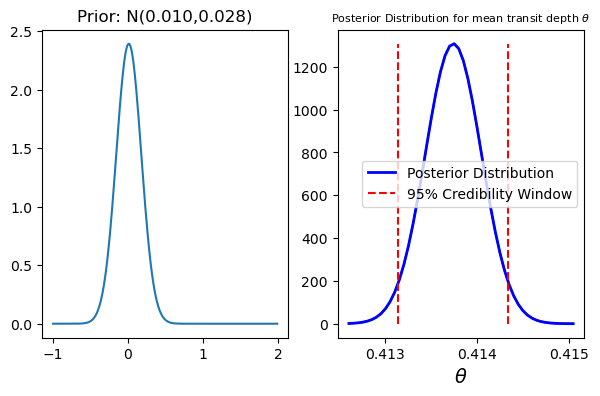

The posterior distribution has a mean of 0.413742, and a credible region of 0.41314 to 0.41434


In [11]:

plotPriorAndPost(a, b, post_mean, post_var)

### Sensitivity Analysis

We will test to see how much the choice of prior changes the posterior mean and credibility region. We will test our chosen prior against 3 different priors, namely:
* $\nu(\theta) \sim N(0.5, \frac{1}{4})$
        We keep mean $a$ the same, but increase the variance $b$ so that the values zero and one are one standard deviation away from $a$.
* $\nu(\theta) \sim N(0.9, \frac{1}{36})$
        We change the mean to be greater, meaning the exoplanet has a greater radius **(???)**, and keep the variance the same.
* $\nu(\theta) \sim N(0.1, \frac{1}{36})$
         We change the mean to be smaller, meaning the exoplanet has a smaller radius **(???)**, and keep the variance the same.

We will test to see how much the choice of prior changes the posterior mean and credibility region. We will test our chosen prior against 4 different priors, namely:
- $\nu(\theta) \sim N(0.01, \frac{1}{4})$
  
 We keep mean $a$ the same, but increase the variance $b$. This tests our assumption on the range of the transit depth of our exoplanet.

- $\nu(\theta) \sim N(0.01, 1)$

 We keep mean $a$ the same, but increase the vairance $b$ to be $1$. This is a very large value given our parameter space, and used to see what happens when we let the variance be very large.

- $\nu(\theta) \sim N(0.5, \frac{1}{36})$
 
 We change the mean to be greater, giving the exoplanet's transit depth larger possible values (meaning the exoplanet has a greater radius), **(???)** and keep the variance the same. In this case, the chosen variance makes both zero and one 3 standard deviations away from the mean, giving any values outside of our parameter space a very low probability, which might be more desirable

- $\nu(\theta) \sim N(0.001, \frac{1}{36})$

 We change the mean to be smaller, and keep the variance the same.

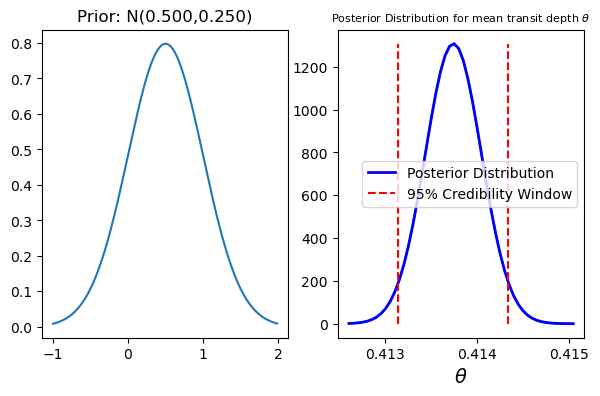

The posterior distribution has a mean of 0.413743, and a credible region of 0.41315 to 0.41434


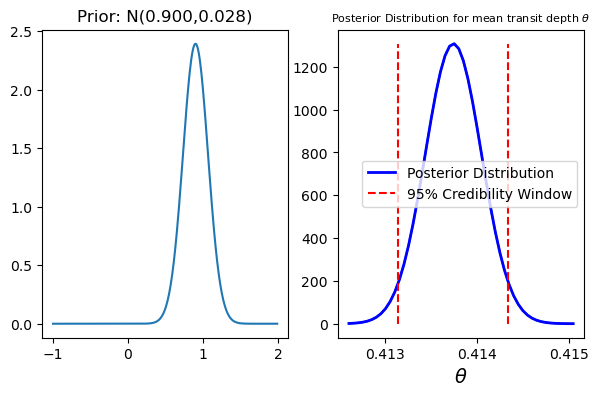

The posterior distribution has a mean of 0.413745, and a credible region of 0.41315 to 0.41434


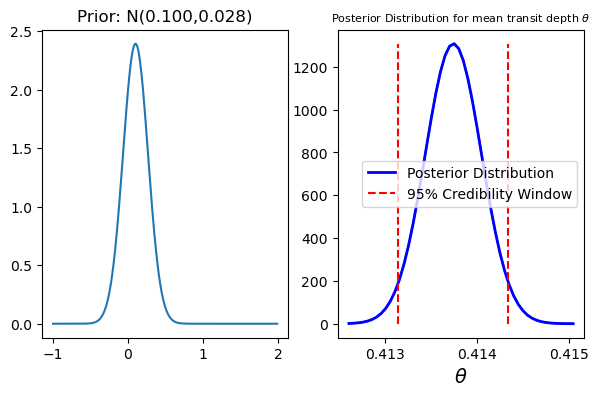

The posterior distribution has a mean of 0.413742, and a credible region of 0.41314 to 0.41434


In [9]:
# putting prior parameters into list of lists
prior_params = [[0.5, (1/4)], [0.9, (1/36)], [0.1, (1/36)]]

# plot all the different priors and posteriors
for p in prior_params:

    # call functions to calculate the posterior mean and variance
    p_v = findVar(nobs, v, p[1])
    p_m = findMean(nobs, xbar, v, p[0], p[1], p_v)

    # call function to plot prior and posterior distribution
    plotPriorAndPost(p[0], p[1], p_m, p_v)


We see that regardless of prior, our posterior mean only varies in the millionths, and given our amount of data, that is not significant. Further, our credibility regions are aslo extremely similar, so we can say our posterior is not very sensitive to the choice of prior parameters.

As we can see, the posterior mean and credible regions for the different priors are extremely similar. This is probably due to our small sample size, as well as the very small range of our transit depth measurements.

We do see that whenever the variance $b$ is $\frac{1}{36}$, our posterior mean is smaller than when $b$ is larger. However, this is in the 8th decimal place, which is much too small to take into account given our sample size.

Thus, we conclude that our posterior distribution is not sensitive to different priors.

### Prior Predictive Check

To asses wheter our prior is sensible about our random variable X, we will simulate from the prior predictive distribution:
$$
m(x) = \int_{\Theta} p(x | \theta)\nu(\theta)d\theta = 
$$

We will 

pymc prior predictive check [link](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html)